# IOI complexity and event density

## Import dependencies, set constants etc.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from src import utils
from src.features.rhythm_features import IOIComplexity, get_beats_from_matched_onsets
from src.visualise.complexity_plots import *

In [4]:
fracs = [1, 1/2, 5/12, 3/8, 1/3, 1/4, 1/6, 1/8, 1/12, 0]
fracs_s = [r'>$\frac{1}{2}$', r'$\frac{1}{2}$', r'$\frac{5}{12}$', r'$\frac{3}{8}$', r'$\frac{1}{3}$', r'$\frac{1}{4}$', r'$\frac{1}{6}$', r'$\frac{1}{8}$', r'$\frac{1}{12}$', r'<$\frac{1}{12}$']
assert sorted(fracs, reverse=True) == fracs

## Load in data

In [3]:
onsets = utils.load_corpus_from_files(fr'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

## Extract all binned IOIs (no rolling window)

In [16]:
res = []
for instr in ['piano']:
    for track in onsets:
        if not track.item['in_30_corpus']:
            continue
        # These are the beat timestamps from the matched onsets
        band_beats = get_beats_from_matched_onsets(track.summary_dict)
        # The tempo and time signature of the track
        tempo = (band_beats.diff()).mean()
        iois = pd.Series(track.ons[instr]).diff().dropna().to_list()
        for ioi in iois:
            prop_ioi = ioi / tempo
            if prop_ioi > 4:
                continue
            prop_ioi /= 4
            bin_ = min(fracs, key=lambda x: abs(x - prop_ioi))
            res.append(dict(instr=instr, ioi=ioi, prop_ioi=prop_ioi, bin=bin_))
rhythm = pd.DataFrame(res)

In [17]:
rhythm.head()

,instr,ioi,prop_ioi,bin
0,piano,0.21,0.136993,0.125000
1,piano,0.26,0.169611,0.166667
2,piano,0.09,0.058711,0.083333
3,piano,0.16,0.104376,0.125000
4,piano,0.11,0.071758,0.083333


## Stacked bar plot of all IOIs

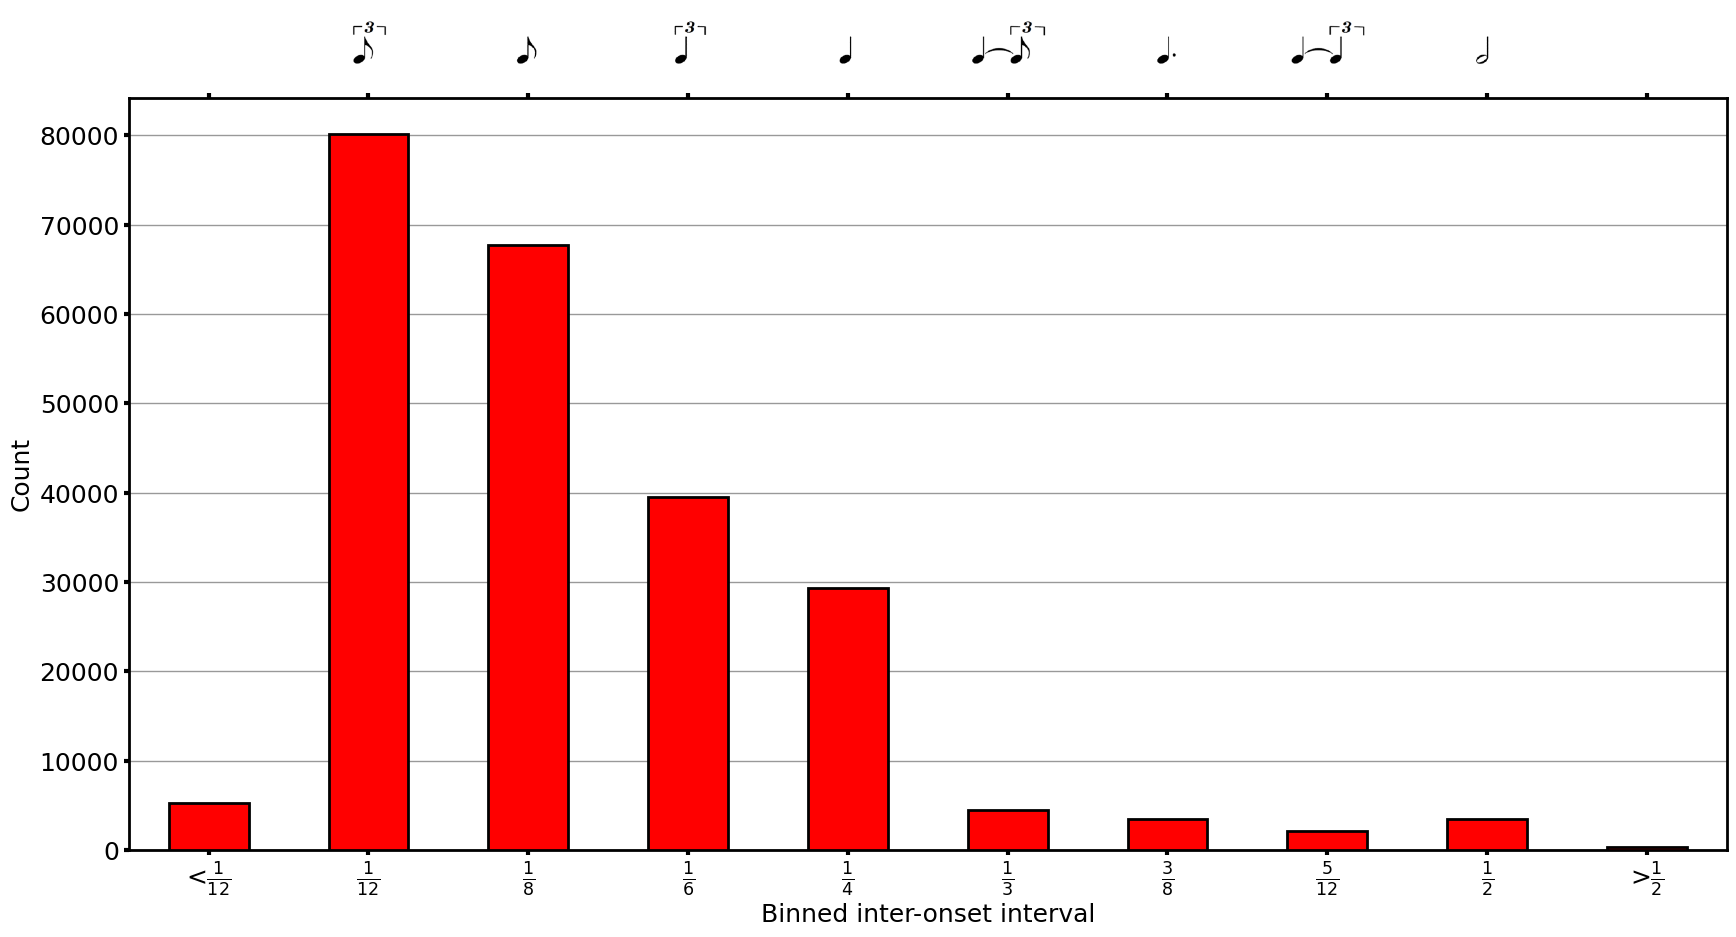

In [26]:
BarPlotTotalBins(rhythm).create_plot()
plt.show()

In [ ]:
rhythm.shape

In [ ]:
rhythm['bin'].value_counts(normalize=False)

## Extract rolling mean complexity and density (with `Extractor` class)

In [ ]:
cdfs = []
total_score = 0
for num, t in enumerate(onsets):
    if not t.item['in_30_corpus']:
        continue
    print(f'{num} / {len(onsets)}')
    downbeats = t.ons['downbeats_auto']
    # These are the beat timestamps from the matched onsets
    band_beats = get_beats_from_matched_onsets(t.summary_dict)
    # The tempo and time signature of the track
    tempo = (60 / band_beats.diff()).mean()
    time_signature = t.item['time_signature']
    # if time_signature == 3:
    #     continue
    for instr in ['piano']:
        my_onsets = t.ons[instr]
        cdf = IOIComplexity(
            my_onsets=my_onsets,
            downbeats=downbeats,
            tempo=tempo,
            time_signature=time_signature
        )
        total_score += len(cdf.complexity_df)
        cdf = cdf.complexity_df.mean().to_dict()
        cdf['mbz_id'] = t.item['mbz_id']
        cdf['instr'] = instr
        cdf['tempo'] = t.tempo
        cdfs.append(cdf)
print(total_score)

## Get the correlation of onset density and complexity

In [ ]:
average = pd.DataFrame(cdfs).drop(columns=['bar_range']).dropna(subset=['lz77', 'n_onsets'])
average['n_onsets'] = average['n_onsets'].astype(float)
average.head()

In [ ]:
1 - average.corr() ** 2

In [ ]:
average.shape

## Bootstrap mean complexity/density

In [ ]:
average.groupby('instr').mean(numeric_only=True)

In [ ]:
for idx, grp in average.groupby('instr'):
    for var in ['n_onsets', 'lz77']:
        true_mean = grp[var].mean()
        boots = [grp[var].sample(frac=1, replace=True, random_state=i).mean() for i in range(100)]
        low, high = np.percentile(boots, 2.5,), np.percentile(boots, 97.5)
        print(idx, var, low, true_mean, high)

## Plot average complexity and density

In [ ]:
BarPlotComplexityDensity(average).create_plot()
plt.show()

## Plot relationships between tempo and complexity/density

In [ ]:
RegPlotTempoDensityComplexity(average).create_plot()
plt.show()

In [ ]:
stats.pearsonr(average.dropna()['tempo'], average.dropna()['n_onsets'])

In [ ]:
average.dropna().shape

## Get average window density and complexity per pianist

In [ ]:
cdfs = []
for num, t in enumerate(onsets):
    if not t.item['in_30_corpus']:
        continue
    print(f'{num} / {len(onsets)}')
    downbeats = t.ons['downbeats_auto']
    # These are the beat timestamps from the matched onsets
    band_beats = get_beats_from_matched_onsets(t.summary_dict)
    # The tempo and time signature of the track
    tempo = (60 / band_beats.diff()).mean()
    time_signature = t.item['time_signature']
    for instr in ['piano']:
        my_onsets = t.ons[instr]
        cdf = IOIComplexity(
            my_onsets=my_onsets,
            downbeats=downbeats,
            tempo=tempo,
            time_signature=time_signature
        )
        for idx, val in cdf.complexity_df.iterrows():
            cdfs.append(dict(
                bandleader=t.item['bandleader'],
                instr=instr,
                lz77=val['lz77'],
                n_onsets=val['n_onsets']
            ))
cdf = pd.DataFrame(cdfs)

In [10]:
cdf.groupby('bandleader')['n_onsets'].describe().sort_values(by='std')

,count,mean,std,min,25%,50%,75%,max
bandleader,,,,,,,,
Bill Evans,2239.0,26.193390,6.171994,6.0,22.0,27.0,30.0,59.0
John Hicks,3901.0,26.211997,6.266592,7.0,23.0,26.0,29.0,59.0
Bud Powell,2764.0,25.876628,6.331217,4.0,22.0,25.0,28.0,51.0
Keith Jarrett,5163.0,24.795855,6.570348,8.0,20.0,24.0,28.0,62.0
Tommy Flanagan,3392.0,24.234375,6.624901,7.0,20.0,24.0,27.0,57.0
Kenny Barron,4945.0,25.931850,8.460240,8.0,21.0,25.0,28.0,75.0
Oscar Peterson,1865.0,33.041287,9.701329,7.0,27.0,31.0,37.0,72.0
McCoy Tyner,3711.0,24.603611,10.178858,3.0,17.0,24.0,30.0,70.0
Junior Mance,3393.0,28.830828,10.441618,1.0,21.0,26.0,34.0,72.0


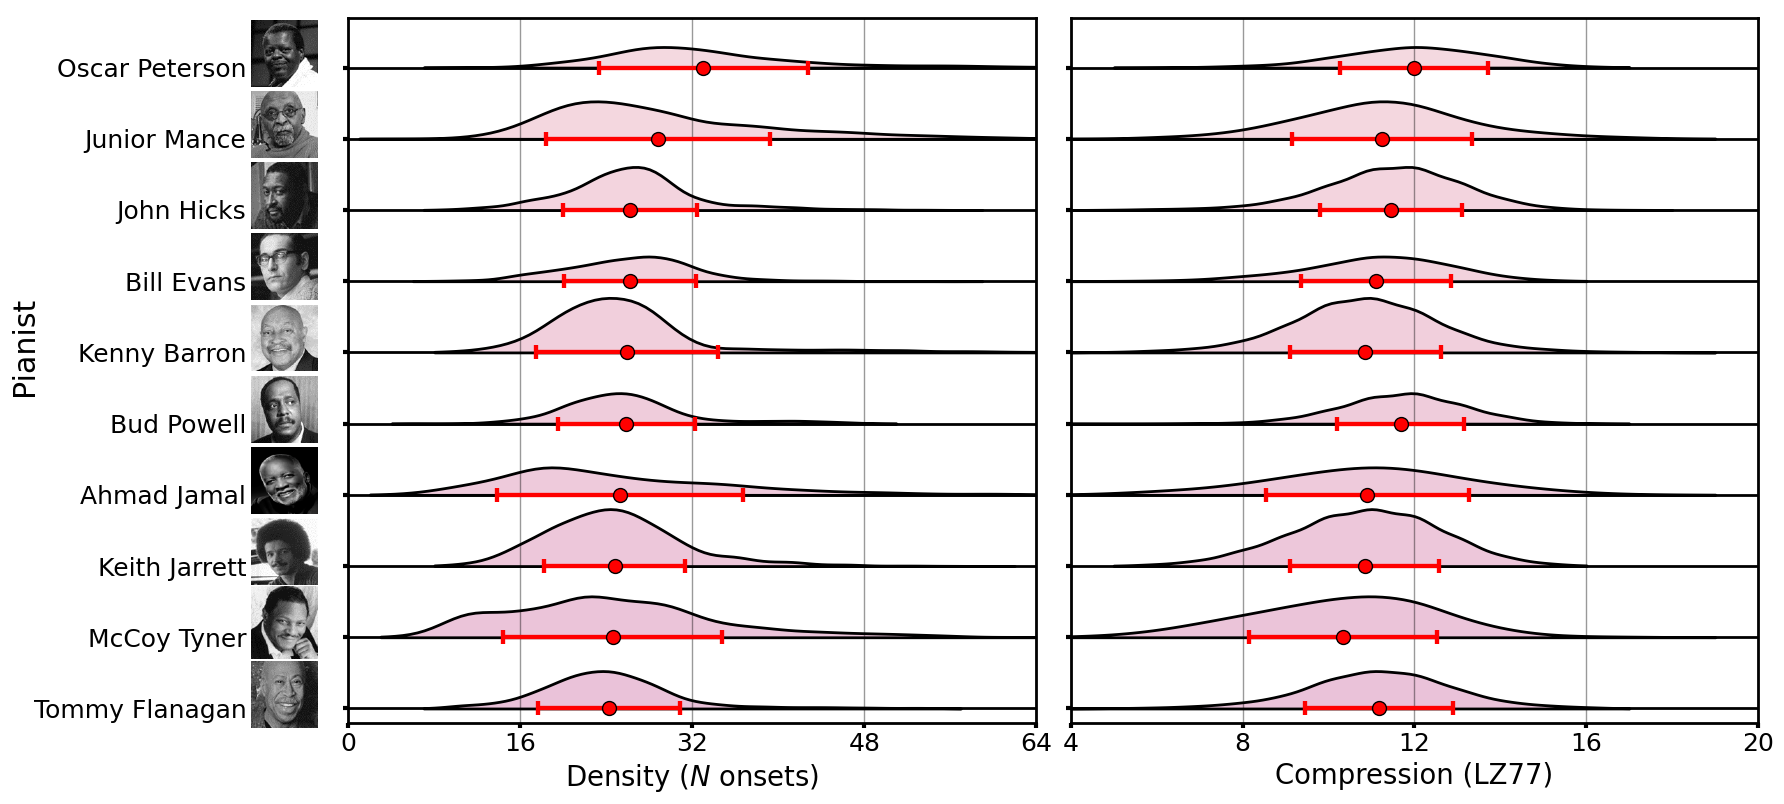

In [146]:
ViolinPlotOnsetComplexity(cdf).create_plot()